In [45]:

# Import Libraries
import pandas as pd 
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Attention, Bidirectional, Dense, Dropout, Embedding, Conv1D, GlobalAveragePooling1D, Input, LSTM, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
df = pd.read_csv("../Datasets/Sarcasm_Headlines_Dataset_v2.csv")
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

(-0.5, 499.5, 499.5, -0.5)

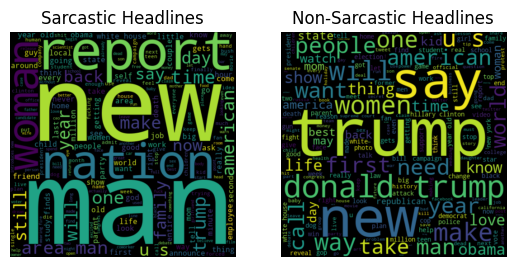

In [47]:
# Separating into sarcastic & non-sarcastic 
sarcastic = " ".join(df[df['is_sarcastic'] == 1]['headline'].astype(str))
non_sarcastic = " ".join(df[df['is_sarcastic'] == 0]['headline'].astype(str))

#print("sarcastic", sarcastic)
#print("non-sarcastic", non_sarcastic)

# Generate Word Cloud
wc_sarcastic = WordCloud(width = 500, height = 500, background_color = "black").generate(sarcastic)
wc_non_sarcastic = WordCloud(width = 500, height = 500, background_color = "black").generate(non_sarcastic)

# Plot Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(wc_sarcastic, interpolation="bilinear")
plt.title("Sarcastic Headlines")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc_non_sarcastic, interpolation="bilinear")
plt.title("Non-Sarcastic Headlines")
plt.axis("off")

In [48]:
# Change to lowercase for all
df['cleaned_headline'] = df['headline'].apply(lambda x: x.lower())  

# Change words to integer, keep max of 20000 most frequent words
tokenizer = Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(df['cleaned_headline'])
sequences = tokenizer.texts_to_sequences(df['cleaned_headline'])

# Pad with 0 if headlines less than 40 words for uniform length
MAX_HEADLINE_LENGTH = 40 
X = pad_sequences(sequences, maxlen = MAX_HEADLINE_LENGTH)

# 1 = sarcastic, 0 = non-sarcastic
y = df['is_sarcastic'].values

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [49]:
# Model: CNN + LSTM + Attention
DENSE_UNITS = 64
MAX_HEADLINE_LENGTH = 40 
VOCAB_SIZE = 20000 

# Model embedding
text_input = Input(shape=(MAX_HEADLINE_LENGTH,), dtype=tf.int32, name="text_input")
embedded_words = Embedding(input_dim=VOCAB_SIZE, 
                            output_dim = 300, 
                            input_length=MAX_HEADLINE_LENGTH)(text_input)

# CNN for feature extraction, can change the different values to experiment
cnn_layer_conv = Conv1D(filters = 128, kernel_size = 3, activation='relu')(embedded_words)
cnn_layer = MaxPooling1D(pool_size = 2)(cnn_layer_conv)

# Bidirectional LSTM
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(cnn_layer)

# Attention to highlight impt parts of the sentence
attention_layer = Attention()([bilstm_layer, bilstm_layer])

# GlobalAveragePooling1D (idea from one of the website on kaggle)
pooling_layer = GlobalAveragePooling1D()(attention_layer)

# Dense + Dropout layer 
dense_layer = Dense(64, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output = Dense(1, activation = 'sigmoid')(dropout_layer)

# Compile the model
CNN_LSTM_model = Model(inputs = text_input, outputs = output)
CNN_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
CNN_LSTM_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 40, 300)   │  6,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 38, 128)   │    115,328 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 19, 128)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 19, 256)   │    263,168 │ max_pooling1d_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 19, 256)   │          0 │ bidirectional_4[… │
│ (Attention)         │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_4[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     16,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,185,029 (73.19 MB)

 Trainable params: 6,395,009 (24.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,790,020 (48.79 MB)

In [50]:
# Train
training = CNN_LSTM_model.fit(X_train, y_train, epochs = 5, batch_size = 64, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_accuracy = CNN_LSTM_model.evaluate(X_test, y_test)
print(f"Accuracy: {test_accuracy:.4f}%")

# Predict
predictions = CNN_LSTM_model.predict(X_test)



Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.7289 - loss: 0.5084 - val_accuracy: 0.8531 - val_loss: 0.3288
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9374 - loss: 0.1731 - val_accuracy: 0.8650 - val_loss: 0.3384
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9822 - loss: 0.0559 - val_accuracy: 0.8564 - val_loss: 0.4887
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9939 - loss: 0.0233 - val_accuracy: 0.8527 - val_loss: 0.6608
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9977 - loss: 0.0089 - val_accuracy: 0.8552 - val_loss: 0.6547
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8574 - loss: 0.6619
Accuracy: 0.8552%
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
